## **Personalized Medicine: Redefining Cancer Treatment**

[Kaggle - Personalized Medicine: Redefining Cancer Treatment](https://www.kaggle.com/competitions/msk-redefining-cancer-treatment/overview)
### **Problem statement**
In this problem we develop algorithms to classify genetic mutations based on clinical evidence (text).

### **Mapping real world problem to ML problem**
* There are nine different classes a genetic mutation can be classified on.
* Multi-Class Classification problem

### **Business objectives**
*   The cost of a mis-classification can be very high.
*   Provide the probability that each data-point belonging to each of the nine classes for better interpretation.
*   Interpretability is important. (Will be useful for Diagnosis)
*   No-strict latency requirements.

### **Performance metric**
* Cross entropy
* Confusion matrix

### **Overview of the Data set**
* **training_variants** provides the information about the genetic mutations.
* **training_text** provides the clinical evidence (text) that human experts used to classify the genetic mutations. Both are linked via the ID field.

#### **training_variants** 
> A comma separated file containing the description of the genetic mutations used for training.
* **ID** : The id of the row used to link the mutation to the clinical evidence
* **Gene** : The gene where this genetic mutation is located
* **Variation** : The aminoacid change for this mutations
* **Class** : The class (1-9) this genetic mutation has been classified into

#### **training_text**
>  A double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations.
* **ID** : the id of the row used to link the clinical evidence to the genetic mutation
* **Text** : the clinical evidence used to classify the genetic mutation

**Train-Test Split:**

* We build train and test by randomly splitting in the ratio of 70:30

## **Import Libraries**

In [ ]:
# Baisc Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
import joblib
import pickle

import os
from pathlib import Path
import glob
from tqdm import tqdm
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

# Text processing Libraries
import re
import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from string import punctuation 
from wordcloud import WordCloud, STOPWORDS

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import log_loss, f1_score, precision_score, recall_score,  accuracy_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.manifold import TSNE

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline, make_pipeline, plot_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config # Display Pipeline
set_config(display='diagram')
# !pip install xgboost-gpu

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, concatenate, LSTM, CuDNNLSTM, Dense, BatchNormalization, Dropout
from keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##**1.Load Dataset**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/ML_CaseStudies/2_Cancer_Diagnosis/

/content/drive/MyDrive/Colab Notebooks/ML_CaseStudies/2_Cancer_Diagnosis


In [ ]:
# load training_variants
df = pd.read_csv("data/training_variants")
print("No. of data points:", df.shape[0])
print("Features: ", df.columns.values)
df.head()

No. of data points: 3321
Features:  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [ ]:
# load training_text # Note: the seperator is ||
df_text = pd.read_csv("data/training_text", sep = "\|\|", engine = "python", names = ["ID", "text"], skiprows =1)
print("No. of data points:", df_text.shape[0])
print("Features: ", df_text.columns.values)

df_text.head()

No. of data points: 3321
Features:  ['ID' 'text']


,ID,text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [ ]:
# merge training_variants and training_text
df = df.merge(df_text, on = "ID", how = "left")
print("shape of dataframe after merging ", df.shape)
# convert column names to lowercase
df.columns = df.columns.str.lower()
df.head()

shape of dataframe after merging  (3321, 5)


,id,gene,variation,class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


## **2. Exploratory Data Analysis**

### **2.1 Distribution of Classes**

In [ ]:
class_counts = df["class"].value_counts()
print(class_counts)

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: class, dtype: int64


[]

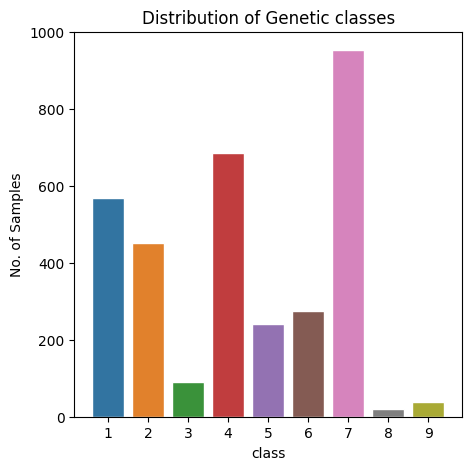

In [ ]:
# plot the number of data points of each class label
fig, ax = plt.subplots(figsize = (5,5))
sns.set_style("whitegrid")
sns.barplot(x = class_counts.index, y = class_counts.array, ax =ax)
ax.set_xlabel("class")
ax.set_ylabel("No. of Samples")
ax.set_title("Distribution of Genetic classes")
ax.plot()

#### **Observations**
* Imbalanced distribution of data among the classes
* Class 3,8,9 have very few samples
* Class 7 have high number of samples






### **2.2 Check null values**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3321 non-null   int64 
 1   gene       3321 non-null   object
 2   variation  3321 non-null   object
 3   class      3321 non-null   int64 
 4   text       3316 non-null   object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [ ]:
df.isna().sum()

id           0
gene         0
variation    0
class        0
text         5
dtype: int64

In [ ]:
df[df.isna().any(axis=1)]

,id,gene,variation,class,text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [ ]:
# replace the null values in text with the text as "gene" + "variation"
df.loc[df.text.isnull(), "text"] = df["gene"] + " " + df["variation"]
df[df["id"]==1109]

,id,gene,variation,class,text
1109,1109,FANCA,S1088F,1,FANCA S1088F


## **3. Preprocessing data**

In [ ]:
# replacing the multiple spaces with underscores
df.gene      = df.gene.str.replace('\s+', '_')
df.variation = df.variation.str.replace('\s+', '_')

In [ ]:
def preprocess(text_list):
    """
    To pre-process the text column in the dataframe
    """

    # load stopwords
    stoplist = set(stopwords.words('english') + list(punctuation) + ["--"])
    # stemmer = PorterStemmer()

    clean_text_list = []
    for text in tqdm(text_list):

        # convert to lower case
        text = str(text).lower()

        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', text)

        # replace multiple spaces with single space
        text = re.sub('\s+',' ', text)

        # remove punctuation marks
        text = re.sub(r'[^\w\s]*', '', text)

        # remove stopwords and perform stemming
        # words = [stemmer.stem(word) for word in word_tokenize(text) if ((word not in stoplist) and (stemmer.stem(word) not in stoplist))]
        words = [word for word in word_tokenize(text) if (word not in stoplist)]
        text = " ".join(words)

        clean_text_list.append(text)

    return np.array(clean_text_list)

In [ ]:
df["clean_text"] = preprocess(df["text"])

100%|██████████| 3321/3321 [04:43<00:00, 11.70it/s]


## **Save Data and Load Back** 

In [ ]:
if not os.path.isfile("data/clean_data.csv"):
    df.to_csv("data/clean_data.csv", index = False)

df = pd.read_csv("data/clean_data.csv")

In [ ]:
df.head()

,id,gene,variation,class,text,clean_text
0,0,FAM58A,Truncating_Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclindependent kinases cdks regulate variety ...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,abstract background nonsmall cell lung cancer ...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,abstract background nonsmall cell lung cancer ...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations monomeric casitas blineage...


## **4. Train Test Split**

In [ ]:
# read the x and y from df
x, y = df[['gene','variation','clean_text']], df['class']
# train test split of x and y
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.2, random_state = 33)

In [ ]:
print("shape of x_train and y_train", x_train.shape, y_train.shape)

shape of x_train and y_train (2656, 3) (2656,)


## **Utility Functions**

In [ ]:
def heatmp_mat(M, name, ax):
    """ This function represents confusion matrix in heatmap format """
    labels = list(range(1,10))
    # cmap =sns.light_palette("blue") #"YlGnBu"
    sns.heatmap(M, annot=True,  fmt=".3f", cmap = "YlGnBu", xticklabels=labels, yticklabels=labels, ax =ax)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Original Class')
    ax.set_title(name, fontsize=10)

def plot_confusion_matrix(test_y, predict_y):
    """ This function plots the confusion matrices given test_y, predict_y """

    C = confusion_matrix(test_y, predict_y)
    B =(C/C.sum(axis=0))
    A =(((C.T)/(C.sum(axis=1))).T)

    fig,ax = plt.subplots(nrows=3, ncols=1,figsize=(15,15))
    heatmp_mat(C, "Confusion matrix", ax = ax[0])
    heatmp_mat(B, "Precision matrix (Columm Sum=1)", ax = ax[1])
    heatmp_mat(A, "Recall matrix (Row sum=1)", ax = ax[2])
    plt.show()

def print_scores(test_y, predict_y):
    """ This function calculates and prints the scores given test_y, predict_y """

    acc_test = balanced_accuracy_score(test_y,predict_y)*100
    print("Balanced accuracy  is {0:.2f}%".format(acc_test))

    precision = precision_score(test_y,predict_y, average = 'weighted')*100
    print("precision score : {0:.2f}%".format(round(precision,2)))

    recall= recall_score(test_y,predict_y, average = 'weighted')*100
    print("Recall score : {0:.2f}%" .format(round(recall,2)))

    f1score = f1_score(test_y,predict_y, average = 'weighted')*100
    print("F1-score : {0:.2f}%".format(round(f1score,2)))
    return

## **5. Random Model**

Log-Loss using random model 2.493989894843487
Balanced accuracy  is 8.68%
precision score : 17.84%
Recall score : 11.13%
F1-score : 13.11%


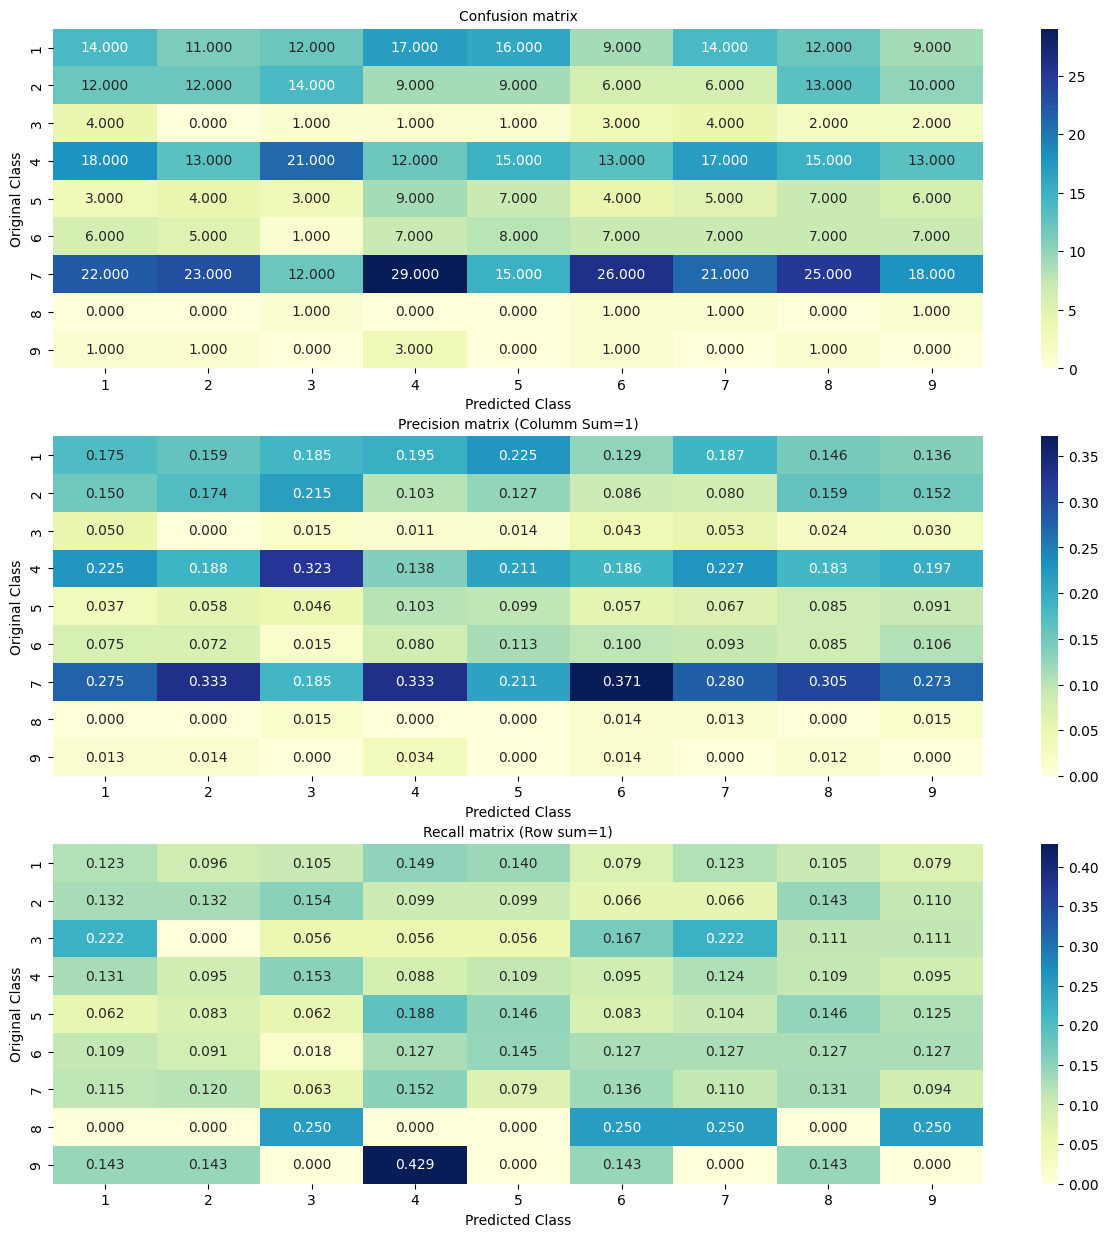

In [ ]:
# Build a random classifier to get a base line for the log-loss to further compare with the ML models
y_pred = np.zeros((len(y_test),9))
for i in range(len(y_test)):
    random_probs = np.random.rand(9)
    y_pred[i] = random_probs/sum(random_probs)

print("Log-Loss using random model", log_loss(y_test, y_pred, eps =1e-15))
y_pred_class = np.argmax(y_pred, axis=1)+1
print_scores(y_test, y_pred_class)
plot_confusion_matrix(y_test, y_pred_class)

## **6. Univariate Analysis**

### **6.1 Univariate analysis : gene feature (categorical)**

In [ ]:
gene_counts = x_train["gene"].value_counts()
print("Number of Unique genes", gene_counts.shape[0])
print("Top 10 frequently occuring genes are\n", gene_counts.head(10))

Number of Unique genes 254
Top 10 frequently occuring genes are
 BRCA1     216
TP53      117
EGFR      108
PTEN      103
BRCA2      96
KIT        78
BRAF       70
ALK        63
ERBB2      53
PDGFRA     50
Name: gene, dtype: int64


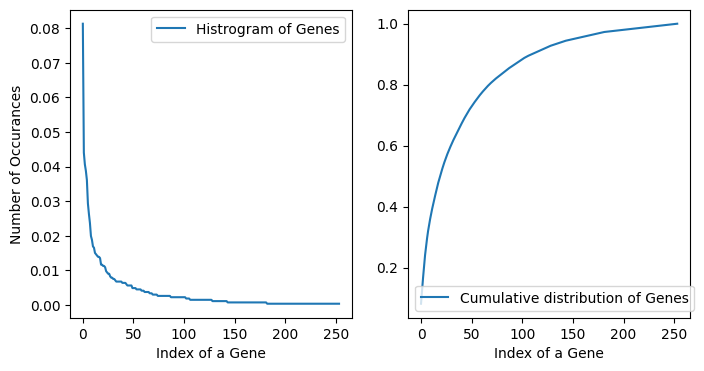

In [ ]:
# plot number of data points of each gene label
gc = gene_counts.values/sum(gene_counts.values)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))

ax1.plot(gc, label="Histrogram of Genes")
ax1.set_xlabel('Index of a Gene')
ax1.set_ylabel('Number of Occurances')
ax1.legend()

# cumulative distribution
c = np.cumsum(gc)
ax2.plot(c,label='Cumulative distribution of Genes')
ax2.set_xlabel('Index of a Gene')
ax2.legend()

fig.show()

In [ ]:
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')

ct1 = ColumnTransformer(transformers = [('ohe_gene', OneHotEncoder(handle_unknown = 'ignore'), [0])], 
                         remainder='drop')

model = SGDClassifier(loss='log', penalty='l2', class_weight='balanced', random_state=42)

pipe = make_pipeline(ct1, model)

# perform cross validation
param_grid = {"sgdclassifier__alpha": [10 ** x for x in range(-5, 3)]}
grid_search = GridSearchCV(pipe, param_grid, scoring="neg_log_loss", cv=3, return_train_score=True, verbose=3, n_jobs=-1)

# calibration
calibrated_model = CalibratedClassifierCV(grid_search, cv=3, method="isotonic", n_jobs=-1)
calibrated_model.fit(x_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=Pipeline(steps=[('columntransformer',
                                                                         ColumnTransformer(transformers=[('ohe_gene',
                                                                                                          OneHotEncoder(handle_unknown='ignore'),
                                                                                                          [0])])),
                                                                        ('sgdclassifier',
                                                                         SGDClassifier(class_weight='balanced',
                                                                                       loss='log',
                                                                                       random_state=42))]),
                                              n_jobs=-1,
                                              param_grid={'sgdclassifier__alpha': [1e-05,
                                                                                   0.0001,
                                                                                   0.001,
                                                                                   0.01,
                                                                                   0.1,
                                                                                   1,
                                                                                   10,
                                                                                   100]},
                                              return_train_score=True,
                                              scoring='neg_log_loss',
                                              verbose=3),
                       method='isotonic', n_jobs=-1)

The train log loss is: 0.9872499080286096
The test log loss is: 1.2624361028191546
Balanced accuracy  is 47.09%
precision score : 58.05%
Recall score : 58.65%
F1-score : 56.04%


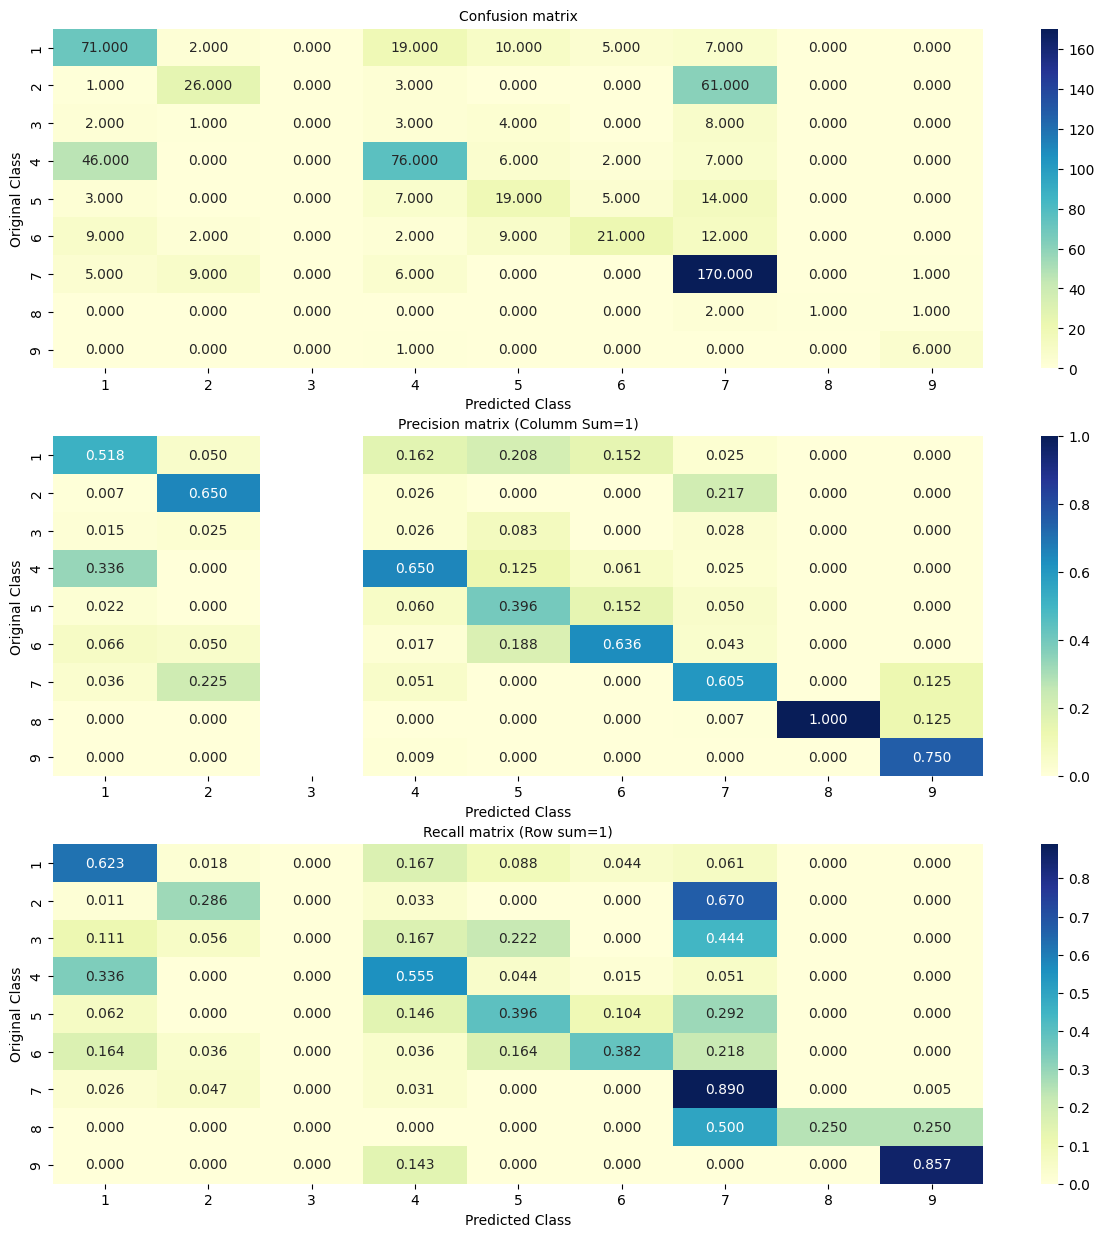

In [ ]:
# Calculate the log loss on the train data and test data
y_train_pred = calibrated_model.predict_proba(x_train)
print("The train log loss is:", log_loss(y_train, y_train_pred, labels=calibrated_model.classes_, eps=1e-15))

y_test_pred = calibrated_model.predict_proba(x_test)
print("The test log loss is:", log_loss(y_test, y_test_pred, labels=calibrated_model.classes_, eps=1e-15))

# prediction of classes
y_pred_class = np.argmax(y_test_pred, axis=1)+1
# print scores and plot confusion matrix
print_scores(y_test, y_pred_class)
plot_confusion_matrix(y_test, y_pred_class)

### **6.2 Univariate analysis : variants feature (categorical)**

In [ ]:
variant_counts = x_train["variation"].value_counts()
print("Number of Unique variants", variant_counts.shape[0])
print("Top 10 frequently occuring variants are\n", variant_counts.head(10))

Number of Unique variants 2409
Top 10 frequently occuring variants are
 Truncating_Mutations    80
Deletion                55
Amplification           53
Fusions                 25
Overexpression           5
T58I                     3
Q61R                     3
G12V                     3
P34R                     2
G13D                     2
Name: variation, dtype: int64


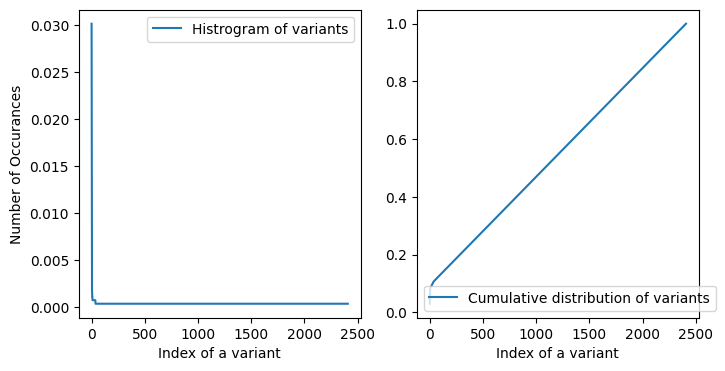

In [ ]:
# plot number of data points of each variant label
gc = variant_counts.values/sum(variant_counts.values)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))

ax1.plot(gc, label="Histrogram of variants")
ax1.set_xlabel('Index of a variant')
ax1.set_ylabel('Number of Occurances')
ax1.legend()

# cumulative distribution
c = np.cumsum(gc)
ax2.plot(c,label='Cumulative distribution of variants')
ax2.set_xlabel('Index of a variant')
ax2.legend()

fig.show()

In [ ]:
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')

ct1 = ColumnTransformer(transformers = [('ohe_variants', OneHotEncoder(handle_unknown = 'ignore'), [1])], 
                         remainder='drop')

model = SGDClassifier(loss='log', penalty='l2', class_weight='balanced', random_state=42)

pipe = make_pipeline(ct1, model)

# perform cross validation
param_grid = {"sgdclassifier__alpha": [10 ** x for x in range(-5, 3)]}
grid_search = GridSearchCV(pipe, param_grid, scoring="neg_log_loss", cv=3, return_train_score=True, verbose=3, n_jobs=-1)

# calibration
calibrated_model = CalibratedClassifierCV(grid_search, cv=3, method="isotonic", n_jobs=-1)
calibrated_model.fit(x_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=Pipeline(steps=[('columntransformer',
                                                                         ColumnTransformer(transformers=[('ohe_variants',
                                                                                                          OneHotEncoder(handle_unknown='ignore'),
                                                                                                          [1])])),
                                                                        ('sgdclassifier',
                                                                         SGDClassifier(class_weight='balanced',
                                                                                       loss='log',
                                                                                       random_state=42))]),
                                              n_jobs=-1,
                                              param_grid={'sgdclassifier__alpha': [1e-05,
                                                                                   0.0001,
                                                                                   0.001,
                                                                                   0.01,
                                                                                   0.1,
                                                                                   1,
                                                                                   10,
                                                                                   100]},
                                              return_train_score=True,
                                              scoring='neg_log_loss',
                                              verbose=3),
                       method='isotonic', n_jobs=-1)

The train log loss is: 1.1139334073870257
The test log loss is: 1.7207233755382376
Balanced accuracy  is 14.74%
precision score : 44.50%
Recall score : 33.98%
F1-score : 22.25%


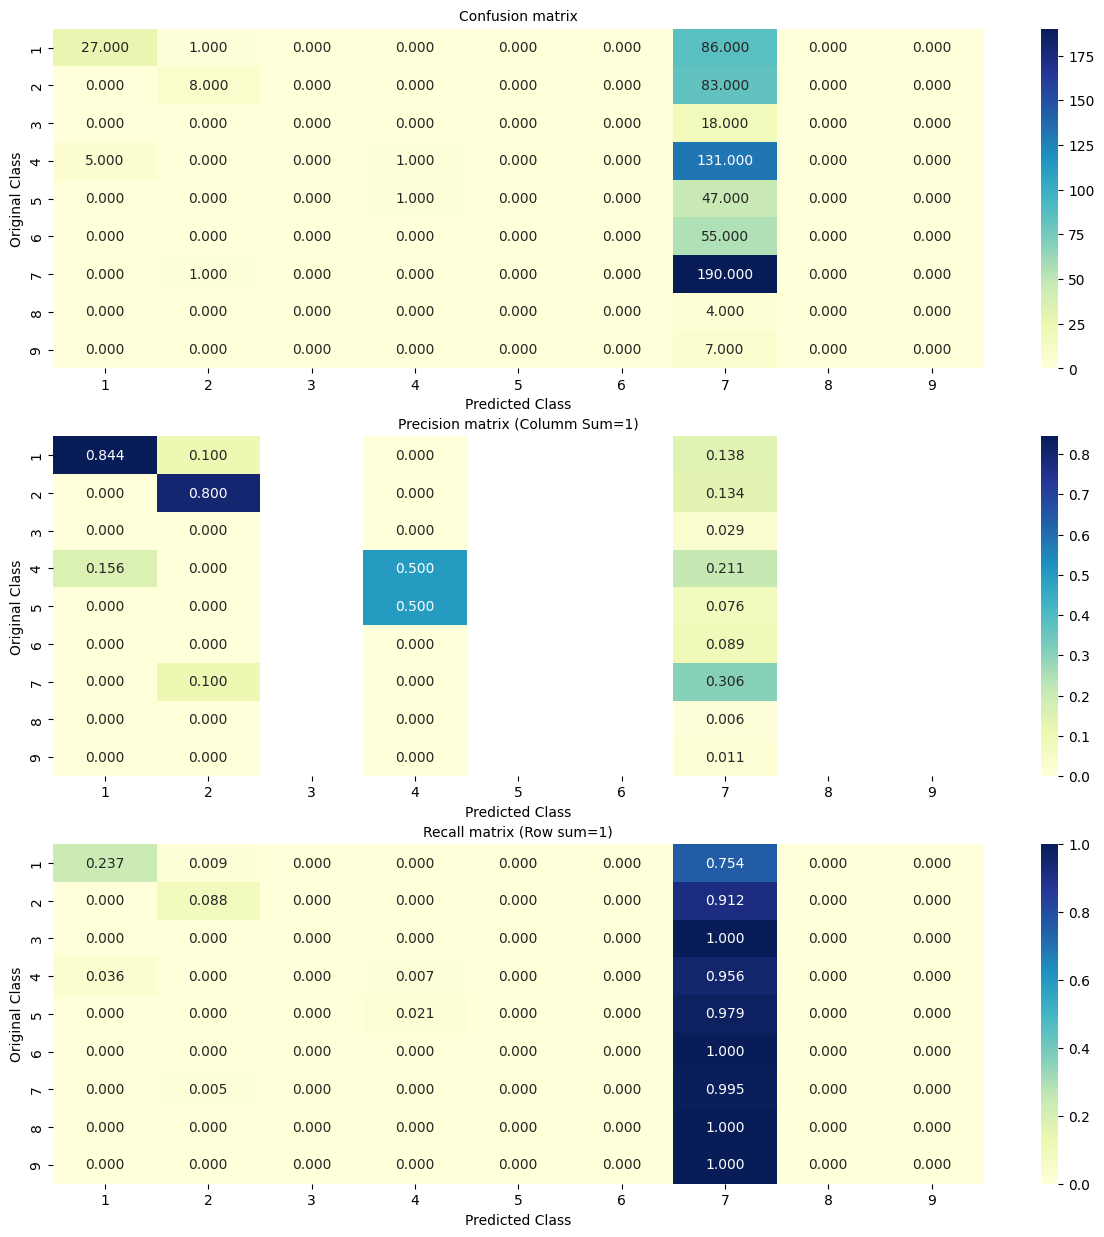

In [ ]:
# Calculate the log loss on the train data and test data
y_train_pred = calibrated_model.predict_proba(x_train)
print("The train log loss is:", log_loss(y_train, y_train_pred, labels=calibrated_model.classes_, eps=1e-15))

y_test_pred = calibrated_model.predict_proba(x_test)
print("The test log loss is:", log_loss(y_test, y_test_pred, labels=calibrated_model.classes_, eps=1e-15))

# prediction of classes
y_pred_class = np.argmax(y_test_pred, axis=1)+1
# print scores and plot confusion matrix
print_scores(y_test, y_pred_class)
plot_confusion_matrix(y_test, y_pred_class)

### **6.3 Univariate analysis : text feature (textual)**

In [ ]:
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')

ct1 = ColumnTransformer(transformers = [('tfidf_text', TfidfVectorizer(max_features = 200), 2)], 
                         remainder='drop')

model = SGDClassifier(loss='log', penalty='l2', class_weight='balanced', random_state=42)

pipe = make_pipeline(ct1, model)

# perform cross validation
param_grid = {"sgdclassifier__alpha": [10 ** x for x in range(-5, 3)]}
grid_search = GridSearchCV(pipe, param_grid, scoring="neg_log_loss", cv=3, return_train_score=True, verbose=3, n_jobs=-1)

# calibration
calibrated_model = CalibratedClassifierCV(grid_search, cv=3, method="isotonic", n_jobs=-1)
calibrated_model.fit(x_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=Pipeline(steps=[('columntransformer',
                                                                         ColumnTransformer(transformers=[('tfidf_text',
                                                                                                          TfidfVectorizer(max_features=200),
                                                                                                          2)])),
                                                                        ('sgdclassifier',
                                                                         SGDClassifier(class_weight='balanced',
                                                                                       loss='log',
                                                                                       random_state=42))]),
                                              n_jobs=-1,
                                              param_grid={'sgdclassifier__alpha': [1e-05,
                                                                                   0.0001,
                                                                                   0.001,
                                                                                   0.01,
                                                                                   0.1,
                                                                                   1,
                                                                                   10,
                                                                                   100]},
                                              return_train_score=True,
                                              scoring='neg_log_loss',
                                              verbose=3),
                       method='isotonic', n_jobs=-1)

The train log loss is: 0.9840633893104691
The test log loss is: 1.1607655133696755
Balanced accuracy  is 45.61%
precision score : 59.44%
Recall score : 59.10%
F1-score : 56.77%


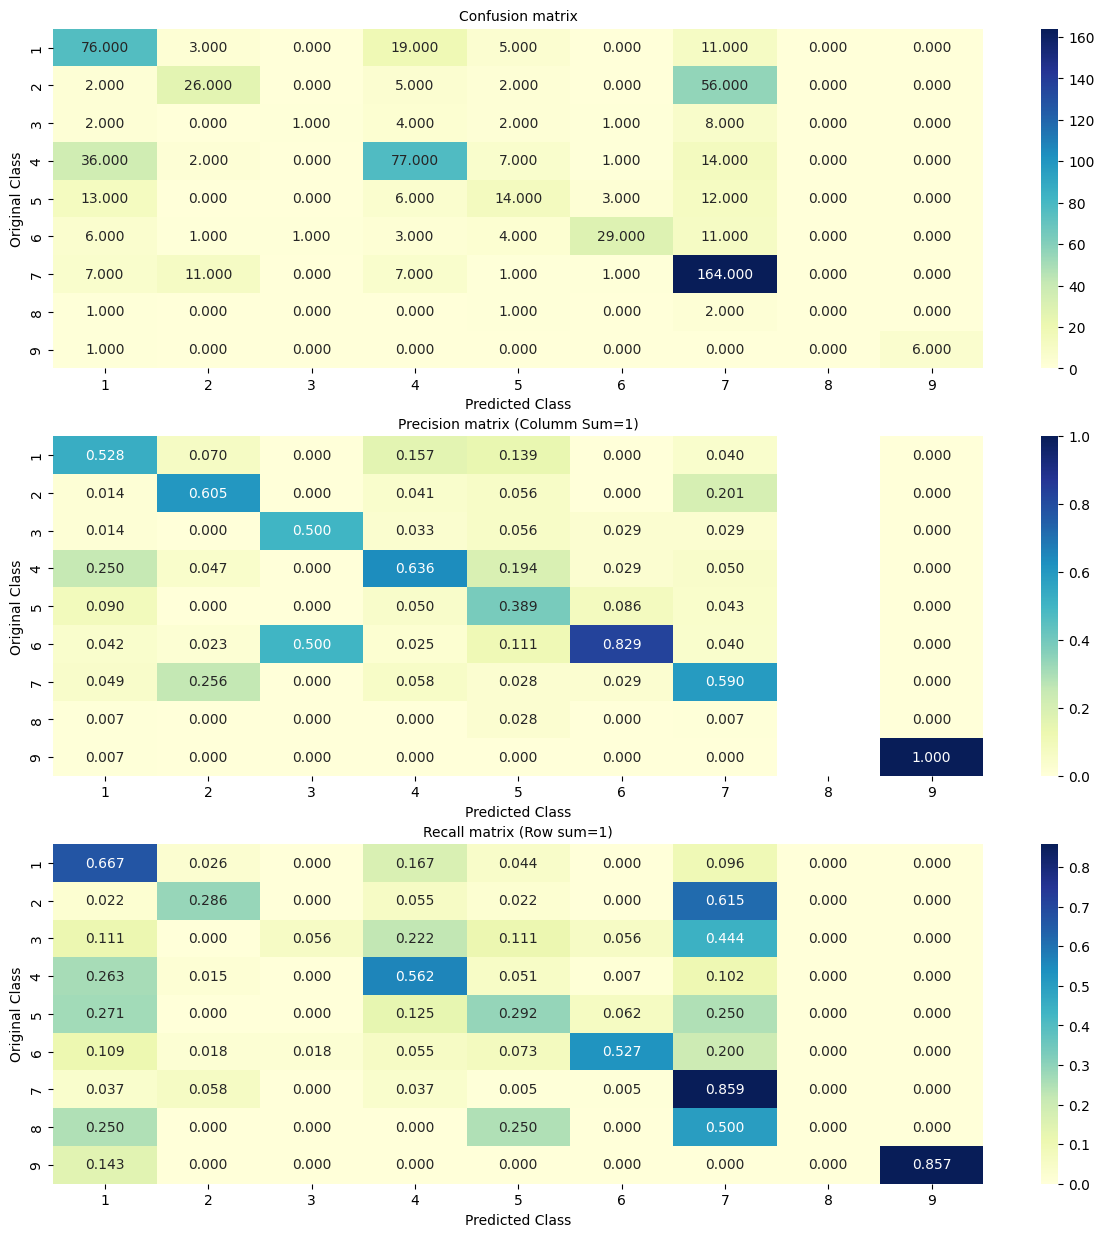

In [55]:
# Calculate the log loss on the train data and test data
y_train_pred = calibrated_model.predict_proba(x_train)
print("The train log loss is:", log_loss(y_train, y_train_pred, labels=calibrated_model.classes_, eps=1e-15))

y_test_pred = calibrated_model.predict_proba(x_test)
print("The test log loss is:", log_loss(y_test, y_test_pred, labels=calibrated_model.classes_, eps=1e-15))

# prediction of classes
y_pred_class = np.argmax(y_test_pred, axis=1)+1
# print scores and plot confusion matrix
print_scores(y_test, y_pred_class)
plot_confusion_matrix(y_test, y_pred_class)